## Benchmarking

In [12]:
from functions import cholesky_tsqr, direct_tsqr, indirect_tsqr

### 1) Changing the number of partitions 

Let's spawn a cluster with 12 workers, organized as follows:

- 1 node (.154): running both the scheduler and the client

- 3 nodes (.216, .116, .113): each running 4 workers (one per core)

In [13]:
from dask.distributed import Client, SSHCluster

cluster = SSHCluster(
    ["10.67.22.154", "10.67.22.216", "10.67.22.116", "10.67.22.113"],
    connect_options={"known_hosts": None},
    remote_python="/home/ubuntu/miniconda3/bin/python",
    scheduler_options={"port": 8786, "dashboard_address": ":8797"},
    worker_options={
        "nprocs": 4,        # We spawn 4 processes for each VM (4-core) -> 12 workers
        "nthreads": 1       # We use 1 threads. Following Dask documentation, however, Numpy should release well the GIL lock thus we could use more than 1 thread. 
    }
)

client = Client(cluster)

2025-09-13 10:02:50,704 - distributed.deploy.ssh - INFO - 2025-09-13 10:02:50,704 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-09-13 10:02:50,706 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda3/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8797 is already in use.
2025-09-13 10:02:50,706 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2025-09-13 10:02:50,707 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 46251 instead
2025-09-13 10:02:50,707 - distributed.deploy.ssh - INFO - warnings.warn(
2025-09-13 10:02:50,724 - distributed.deploy.ssh - INFO - 2025-09-13 10:02:50,724 - distributed.scheduler - INFO - State start
2025-09-13 10:02:50,727 - distributed.deploy.ssh - INFO - 2025-09-13 10:02:50,727 - distributed.scheduler - INFO - Closing scheduler. Reason: failure-to-start-<class 'OSError'>


RuntimeError: Cluster failed to start: Worker failed to start

In [14]:
# Let's see if everything went smoothly
cluster

SSHCluster(SSHCluster, 'tcp://10.67.22.154:8786', workers=12, threads=12, memory=23.25 GiB)

To test our three algorithms (Cholesky, Indirect, Direct), we’ll work with the [HIGGS dataset](https://archive.ics.uci.edu/dataset/280/higgs). This dataset is a great choice because it is large enough to challenge the memory of a standard laptop (making Dask an ideal tool) while still being easy to access from the web. Let’s start by loading it into a`dask.array`.

In [ ]:
import dask.dataframe as dd
import os

os.chdir("/home/ubuntu") 
path_HIGGS = os.getcwd() + "/datasets/HIGGS.csv"

df = dd.read_csv(path_HIGGS, header=None, blocksize="200MB")    # The block size can be customized, let's start with 200 MB
X_df = df.iloc[:, 1:] 
X_da = X_df.to_dask_array(lengths=True)   # We want it as a matrix (an array, that is)

At this stage, Dask has analyzed the dataset and set up the partitioning, but the chunks haven’t yet been sent to the workers. Let's gather more information on how Dask has planned to partition the dataset (as an array)

In [ ]:
#print some info
X_da

Using blocks of $200 , \text{MB}$, Dask divided the array into $40$ chunks. 
Our first goal now is to study how the performance of each algorithm changes (measured as time taken to run the computations) as the number of partitions varies. In this first experiment, we will keep both the number of workers ($12$) and the dataset fixed.

In [ ]:
import time
from dask.distributed import wait
import numpy as np

# a function to measure execution time
def benchmark(X_da, algorithm, rep = 20, verbose = False):
    res = [] 
    if (verbose): print("Fun:", algorithm.__name__,", completion status: ", end = "")
    # repeat _rep_ timesin
    for _ in range(rep):
        if(verbose): print( _, end = " ")
            
        #start a timer
        start = time.time()
        # launch the function (create the DAG)
        Q, R = algorithm(X_da)
        Q = Q.persist()     # Trigger the computations (but don't send anything to the client)
        R = R.persist()
        wait([Q, R])        # Wait until Q and R are available in the worker's memory ...
        end = time.time()   # .. only then stop the timer
        
        res.append(end-start)
        # Remove Q and R from the worker's memory, so that each run is the same
        client.cancel(Q)
        client.cancel(R)
    if(verbose): print()
    return res

Let’s start analyzing our algorithms. We will loop over different numbers of partitions, repeating each algorithm `rep` times to average out possible variations due to the workload on CloudVeneto.

Before each run, we will repartition `X_da` and persist it, ensuring that the data is already available in the workers’ memory with the correct partitioning.

In [ ]:
# helper function that write to file the measured time in the format:
# n_part avg stddev median mad
def write_stats(filename, part, times):
    avg = np.mean(times)
    std = np.std(times)
    med = np.median(times)
    mad = np.median(np.abs(times - med))
    with open(filename, "a") as f:
        f.write(f"{part} {avg} {std} {med} {mad}\n")

n_partitions = list(range(500, 705, 100))
true_npartitions = []

rep = 10

for i, part in enumerate(n_partitions):
    n = X_da.shape[0]
    sizes = [n // part] * part
    sizes[-1] += n % part 
    X_da = X_da.rechunk({0: sizes, 1: -1}).persist()  # Repartition X_da and persist (save in the worker's memory)
    wait(X_da)   # Wait until Dask has finished to repartition (we don't want to count the time used to repartition)
    print("N. partitions = ", X_da.npartitions)
    true_npartitions.append(X_da.npartitions)
    
    t_cholesky = benchmark(X_da, cholesky_tsqr, rep = rep, verbose = True)
    t_direct = benchmark(X_da, direct_tsqr, rep = rep, verbose = True)
    t_indirect = benchmark(X_da, indirect_tsqr, rep = rep, verbose = True)

    write_stats("./MAPD_project/data/Cholesky_TimeVsPartitions.txt", part, t_cholesky)
    write_stats("./MAPD_project/data/Direct_TimeVsPartitions.txt", part, t_direct)
    write_stats("./MAPD_project/data/Indirect_TimeVsPartitions.txt", part, t_indirect)   

Let's analyze the results:

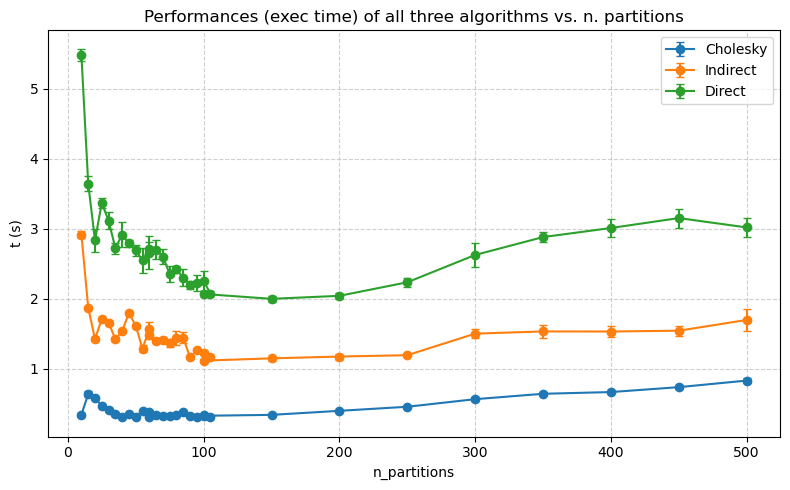

In [11]:
import numpy as np
import matplotlib.pyplot as plt
def load_data(filename):
    data = np.loadtxt(filename, skiprows=1)  
    x = data[:, 0]
    y = data[:, 3]
    err = data[:, 4]
    return x, y, err

files = ["./MAPD_project/data/Cholesky_TimeVsPartitions.txt", "./MAPD_project/data/Indirect_TimeVsPartitions.txt", "MAPD_project/data/Direct_TimeVsPartitions.txt"]
labels = ["Cholesky", "Indirect", "Direct"]
colors = ["tab:blue", "tab:orange", "tab:green"]

plt.figure(figsize=(8, 5))

for fname, label, color in zip(files, labels, colors):
    x, y, err = load_data(fname)
    plt.errorbar(x, y, yerr=err, label=label, color=color,
                 marker='o', linestyle='-', capsize=3)

plt.xlabel("n_partitions")
plt.ylabel("t (s)")
plt.title("Performances (exec time) of all three algorithms vs. n. partitions")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


As a first observation, we can see that the Cholesky-based decomposition achieves significantly better performance compared to the state-of-the-art direct (and indirect) algorithms. At first glance, this might suggest that Cholesky is the best method for performing QR decomposition on large datasets. However, as already mentioned, the Cholesky approach suffers from severe numerical instability issues when the dataset size grows (as in our case).

To check whether the outputs of the functions are reasonable, let's compute some stability metrics. We can compare two matrices by computing:

$$
\text{diff}(A, B) = \max |A - B|
$$

Alternatively, we can test whether a matrix $Q$ is truly orthogonal by computing:

$$
\| Q^T Q - I \|_2
$$
or, as an ulterior accuracy metric, we can verify what's the value of:
$$
acc = ||A-QR||_2 / ||R||_2
$$
Let's first compare Cholesky and Direct:

In [ ]:
from dask.array.linalg import tsqr

Qch, Rch = cholesky_tsqr(X_da)    # Output from Cholesky
Qd, Rd = direct_tsqr(X_da)        # Output from our implementation of Direct method
Qt, Rt = tsqr(X_da)               # Output of official TSQR function in the Dask library

# Now let's trigger the computations
Qch, Rch = Qch.persist(),  Rch.persist()
Qd, Rd = Qd.persist(), Rd.persist()
Qt, Rt = Qt.persist(), Rt.persist()

print("Maximum difference between R_ch and R_dir: ", np.max( np.abs(Rch.T.compute()-Rd.compute()) ))
print("Maximum difference between R_dir and R as computed by the official Dask function: ", np.max(np.abs(Rt.compute()-Rd.compute()) ))

print("***")

print("Maximum difference between Q_ch and Q_dir: ", np.max(np.abs(Qch - Qd)).compute())
print("Maximum difference between Q_dir and Q as computed by the official Dask function: ", np.max(np.abs(Qt - Qd)).compute())

print("***")

print("Ortoghonality test, Cholesky: ||QT Q - I|| = ", np.linalg.norm(np.dot(Qch.T, Qch) - np.eye(Qch.shape[1])).compute())
print("Ortoghonality test, Direct: ||QT Q - I|| = ", np.linalg.norm(np.dot(Qd.T, Qd) - np.eye(Qd.shape[1])).compute())

print("***")

print("Accuracy test, Cholesky: ||A - QR|| / ||R|| = ",(da.linalg.norm(X_da - Qch @ da.from_delayed(Rch.T, shape=(Qch.shape[1], Qch.shape[1]), dtype=Qch.dtype)) / da.linalg.norm(da.from_delayed(Rch.T, shape=(Qch.shape[1], Qch.shape[1]), dtype=Qch.dtype))).compute())
print("Accuracy test, Direct:   ||A - QR|| / ||R|| = ",(da.linalg.norm(X_da - Qd @ Rd) / da.linalg.norm(Rd)).compute())


As expected, the results obtained with the Cholesky method are completely unreliable, whereas the Direct method, although it takes more time, achieves the desired precision.

What about the Indirect method?  The indirect approach is designed as a trade-off between Cholesky and Direct. In principle, it should deliver accuracy close to the Direct QR decomposition regarding $R$ requiring fewer resources and less time, but can be inaccurate on the computation of $Q$.

Let's verify both its numerical stability in practice, to see whether it consistently provides a better balance compared to the other two methods.

In [ ]:
Qi, Ri = indirect_tsqr(X_da)      # Output from indirect method
Qd, Rd = direct_tsqr(X_da)        # Output from our implementation of Direct method

# Now let's trigger the computations
Qi, Ri = Qi.persist(),  Ri.persist()
Qd, Rd = Qd.persist(), Rd.persist()

print("Maximum difference between R_dir and R_indir: ", np.max( np.abs(Ri.compute() - Rd.compute()) ))
print("Maximum difference between Q_dir and Q_indir: ", np.max(np.abs(Qi - Qd)).compute())

print("***")

print("Ortoghonality test, Indirect: ||QT Q - I|| = ", np.linalg.norm(np.dot(Qi.T, Qi) - np.eye(Qi.shape[1])).compute())
print("Ortoghonality test, Direct: ||QT Q - I|| = ", np.linalg.norm(np.dot(Qd.T, Qd) - np.eye(Qd.shape[1])).compute())

print("***")

print("Accuracy test, Indirect: ||A - QR|| / ||R|| = ",(da.linalg.norm(X_da - Qi @ Ri).compute()))
print("Accuracy test, Direct:   ||A - QR|| / ||R|| = ",(da.linalg.norm(X_da - Qd @ Rd) / da.linalg.norm(Rd)).compute())

print("Machine accuracy: ", (np.finfo(float).eps))
u, s, v = da.linalg.svd(X_da)
print("Conditioning number of the matrix:", (s.max() / s.min()).compute() )

It seems that both the indirect and the direct methods achieve optimal results, even though the indirect method takes about half the time compared to the direct one. In practice, the accuracy of the indirect method is significantly better than machine precision.  

This peculiar situation, in which both the direct and indirect algorithms lead to essentially the same result, is probably just a fortunate case. With a more ill-conditioned or larger matrix, the differences in stability and accuracy would likely become much more evident.


In [ ]:
client.close()
cluster.close()

### 2) Changing the number of workers
In the following we will proceed to study the performances of the model with respect to the variation of the number of active workers.

In [ ]:
def run_once(func, A):
    t0 = time.time()
    Q, R = func(A)    # crea DAG e (nel tuo caso) esegue la fattorizzazione
    # portiamo Q e R in RAM dei worker così misuriamo compute vero:
    Q = Q.persist(); R = R if not hasattr(R, "persist") else R.persist()
    wait([Q, R])
    t1 = time.time()
    # pulizia per run comparabili
    client.cancel([Q, R])
    return t1 - t0

workers_list = [1, 2, 4, 8]   # scegli in base alla macchina
rep = 5
results = {}

for w in workers_list:
    cluster.scale(w)                # cambia #worker a runtime
    client.wait_for_workers(w)      # aspetta che siano attivi
    # warm-up leggero (opzionale)
    _ = run_once(indirect_parallel, X_da)
    # misure
    times = [run_once(indirect_parallel, X_da) for _ in range(rep)]
    results[w] = (np.mean(times), np.std(times))
    print(f"workers={w}: mean={np.mean(times):.3f}s  std={np.std(times):.3f}s")
